In [1]:
from pyspark.sql import functions as F
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import matplotlib.dates as mdate
from matplotlib.ticker import NullFormatter
import datetime as dt
import seaborn as sns
import pandas as pd
import numpy as np
import geopy.distance
import matplotlib
import datetime
import pickle
import os

In [2]:
#schema of segment table
schema_segments ='deviceId String,\
                  type Integer,\
                  dateTime string,\
                  startLatitude double,\
                  startLongitude double,\
                  startEngineStatus Integer,\
                  startAccuracyDrop Integer,\
                  endAccuracyDrop Integer,\
                  endEngineStatus Integer,\
                  endLatitude double,\
                  endLongitude double,\
                  segmentDistance double,\
                  segmentDuration double,\
                  segmentSpeedKmH double,\
                  xtmp double,\
                  ytmp double,\
                  start_x integer,\
                  start_y integer,\
                  end_x integer,\
                  end_y integer,\
                  cell_id_start string,\
                  cell_id_end string'
#reading csv
path = os.path.abspath(os.getcwd())
df_segment_hourly = spark.read.csv('file:///%s/segment_table'%path,sep=",", schema = schema_segments)

In [3]:
df_segment_hourly = df_segment_hourly.withColumn('dateTime', F.to_timestamp('dateTime'))

In [4]:
#change date to hour
@F.udf()
def date_to_hour(dateTime):
    hour = dateTime.hour
    return hour

df_segment_hourly = df_segment_hourly.withColumn('dateTime', date_to_hour('dateTime'))

In [5]:
df_segment_hourly.show()

+--------+----+--------+-------------+--------------+-----------------+-----------------+---------------+---------------+-----------+------------+---------------+---------------+------------------+------------------+------------------+-------+-------+-----+-----+-------------+-----------+
|deviceId|type|dateTime|startLatitude|startLongitude|startEngineStatus|startAccuracyDrop|endAccuracyDrop|endEngineStatus|endLatitude|endLongitude|segmentDistance|segmentDuration|   segmentSpeedKmH|              xtmp|              ytmp|start_x|start_y|end_x|end_y|cell_id_start|cell_id_end|
+--------+----+--------+-------------+--------------+-----------------+-----------------+---------------+---------------+-----------+------------+---------------+---------------+------------------+------------------+------------------+-------+-------+-----+-----+-------------+-----------+
| 2506913|   2|      11|      45.0721|       7.70783|                1|                1|              1|              1|   45.071

In [6]:
#creating a new dataframe consisting only hours and their number
#of segments per hour
df_hourly = df_segment_hourly.groupby(['dateTime']).agg(F.count('dateTime'))

In [7]:
df_hourly.show()

+--------+---------------+
|dateTime|count(dateTime)|
+--------+---------------+
|       7|        3479580|
|      15|       15816947|
|      11|       17725300|
|       3|        2051421|
|       8|        9629644|
|      22|       10687575|
|      16|       16983777|
|       0|        6553553|
|       5|        1036131|
|      18|       22151618|
|      17|       19065508|
|       6|        1619105|
|      19|       24805223|
|      23|        7472123|
|       9|       18690127|
|       1|        5262608|
|      20|       23307679|
|      10|       20684905|
|       4|        1234981|
|      12|       17336485|
+--------+---------------+
only showing top 20 rows



In [8]:
df_hourly = df_hourly.withColumn("dateTime",df_hourly.dateTime.cast('int'))
df_hourly = df_hourly.orderBy('dateTime',ascending=True)

In [9]:
df_hourly.show()

+--------+---------------+
|dateTime|count(dateTime)|
+--------+---------------+
|       0|        6553553|
|       1|        5262608|
|       2|        3519391|
|       3|        2051421|
|       4|        1234981|
|       5|        1036131|
|       6|        1619105|
|       7|        3479580|
|       8|        9629644|
|       9|       18690127|
|      10|       20684905|
|      11|       17725300|
|      12|       17336485|
|      13|       17557503|
|      14|       16826836|
|      15|       15816947|
|      16|       16983777|
|      17|       19065508|
|      18|       22151618|
|      19|       24805223|
+--------+---------------+
only showing top 20 rows



In [10]:
df_hourly = df_hourly.toPandas()

In [11]:
df_hourly.columns = ['hour','num_segment']

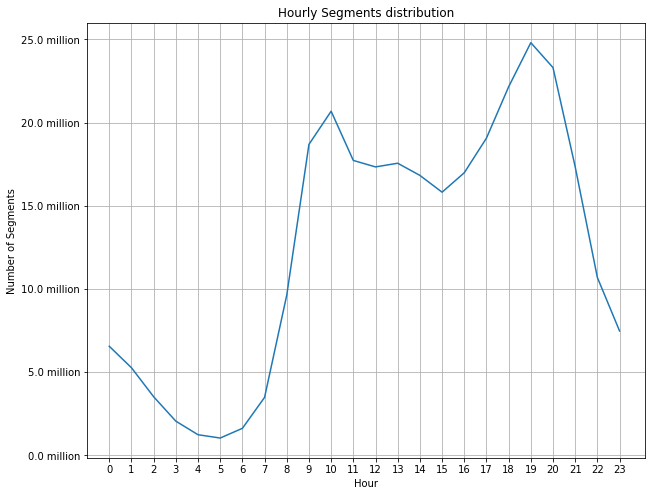

In [14]:
# df_hourly = df_hourly.toPandas()
plt.rcParams["figure.figsize"] = (10,8)
plt.plot(df_hourly['hour'],df_hourly['num_segment'], alpha = 1)
    
plt.xticks(np.arange(24))

def formatter(x, pos):
    return str(round(x / 1e6, 2)) + " million"

plt.gca().yaxis.set_major_formatter(formatter)
plt.gca().yaxis.set_minor_formatter(NullFormatter())
#     fig.subplots_adjust(right = 1.2)
plt.xlim(-1)
# plt.ylim(0,110000)
plt.grid(True)

plt.xlabel("Hour")
plt.ylabel("Number of Segments")
title = "Hourly Segments distribution"
plt.title(title)
plt.savefig(f'{title}.jpg',bbox_inches='tight')
plt.show()

In [13]:
sum(df_hourly['num_segment'])

300841429